<a href="https://colab.research.google.com/github/tohver/Deep-Learning/blob/master/06_Multilabel_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install fastai
 import fastai 
 print(fastai.__version__ )

2.0.0


In [2]:
!pip install -Uqq fastbook
!pip install fastai --upgrade
import fastbook

     |████████████████████████████████| 727kB 4.1MB/s 
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.1.4)


In [4]:
fastbook.setup_book()

Mounted at /content/gdrive


In [5]:
# from fastai import *
from fastbook import *

In [6]:
from fastai.vision.all import *

In [7]:
path = untar_data(URLs.PASCAL_2007)

In [8]:
 path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/train')]

In [9]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


## construct DataLoaders

In [10]:
a = list(enumerate(string.ascii_lowercase))
a[:5], len(a)

([(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd'), (4, 'e')], 26)

In [11]:
dl_a = DataLoader(a, batch_size=8, shuffle=True)
b = first(dl_a)

In [12]:
b

(tensor([ 7, 24, 17, 21,  5, 19,  9, 15]),
 ('h', 'y', 'r', 'v', 'f', 't', 'j', 'p'))

In [13]:
list(zip(b[0], b[1]))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [14]:
# * 

list(zip(*b))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [15]:
a = list('abcde')
dss = Datasets(a)
dss[0]

('a',)

In [16]:
# functions to AAcompute dependent and independent variable (add 'a' or 'b' on the end)
def f1(x): return x+'a'
def f2(x): return x+'b'

In [17]:
dss = Datasets(a, [[f1]])
dss

(#5) [('aa',),('ba',),('ca',),('da',),('ea',)]

In [18]:
# put multple functions: it does multiple things
Datasets(a, [[f1, f2]])

(#5) [('aab',),('bab',),('cab',),('dab',),('eab',)]

In [19]:
# a jeśli tylko w pojedynczym nawiasie, to zrobi tupla inaczej:
# bo: the first lsit of functions builds independent variables - np. open image and convert it to an array, 
# the second list of functions: dependent variables (i.e. function that creates labels from filenames)

dss = Datasets(a,[[f1], [f2]])
dss

(#5) [('aa', 'ab'),('ba', 'bb'),('ca', 'cb'),('da', 'db'),('ea', 'eb')]

In [20]:
# now: dataloaders
dls = DataLoaders.from_dsets(dss, batch_size = 4)
first(dls.train)

(('ea', 'ca', 'da', 'ba'), ('eb', 'cb', 'db', 'bb'))

In [21]:
first(dls.train)

(('da', 'aa', 'ca', 'ba'), ('db', 'ab', 'cb', 'bb'))

# Datablock
what it does

In [22]:
#create empty datablock
dblock = DataBlock()

In [23]:
dsets = dblock.datasets(df)
# it creates train and valid datasets
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [24]:
# and independent and dependent variable
x,y = dsets.train[0]
x

fname         009659.jpg
labels      chair person
is_valid           False
Name: 4856, dtype: object

In [25]:
# the same, then: by default, the data block assumes we have two things: input and target.
y

fname         009659.jpg
labels      chair person
is_valid           False
Name: 4856, dtype: object

In [26]:
dblock = DataBlock(get_x = lambda x: x['fname'], get_y= lambda x: x['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('004558.jpg', 'pottedplant')

In [27]:
# x: independent variable: we we open the images, y - labels, 
# ! x - should be rather with the path

def get_x(x): return path/'train'/x['fname'] # directory path + filename
def get_y(x): return x['labels'].split()

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/003608.jpg'), ['car'])

In [28]:
# To actually open the image and do the conversion to tensors, we will need to use a set of transforms = block types: 

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),  get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x332,
 TensorMultiCategory([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [29]:
# MultiCategoryBlock: od razu konwertuje na liczby
# one hot encoding


In [30]:
dsets.train[0]
# chcemy drugi block, labels:

(PILImage mode=RGB size=500x332,
 TensorMultiCategory([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [31]:
idxs =  torch.where(dsets.train[0][1]==1.)
idxs

(TensorMultiCategory([ 5,  6, 14]),)

In [36]:
# zwróciło tuple, więc:
idxs

(TensorMultiCategory([ 5,  6, 14]),)

In [33]:
dsets.train.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [41]:
dsets.train.vocab[idxs[0]]

(#3) ['bus','car','person']

## splitter
by default: DataBlock uses random split.  
To use the information in the df: we need a function

In [42]:
df[:3]

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True


In [43]:
def splitter(df):
  train = df.index[~df.is_valid].tolist()
  valid = df.index[df.is_valid].tolist()
  return train, valid
  # returns 2 lists of indexes

In [44]:
dblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    splitter = splitter,
    get_x = get_x, get_y = get_y
)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [45]:
# again: to split it to mini batches: dataloader
# + every item must have same size

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x, get_y = get_y,
                   item_tfms = RandomResizedCrop(256, min_scale=.35)
                   )
                   
dls = dblock.dataloaders(df)
# tym razem do dataloader, nie datasets

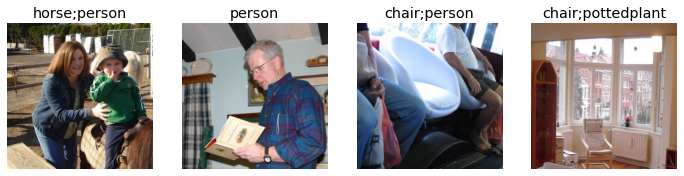

In [46]:
dls.show_batch(nrows = 1, ncols = 4)

# binary cross-entropy

In [47]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [48]:
# to avoid the error: model is on the GPU, but your data is on the CPU
# "RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x,y = dls.train.one_batch()
# to avoid this issue:
# hura, wybrnąłem!!!
# x,y = x.to(device), y.to(device) - gdyby było odwrotnie, tu juz inputs są w cuda, model nie był
learn.model.to(device)

# get activations from the final layer
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [54]:
# zawsze warto sprawdzić shape

In [49]:
device

device(type='cuda', index=0)

In [50]:
# size: 64, 20, cause: batch size = 64, 20 categories
activs[7]

TensorImage([ 0.7319,  0.6979,  0.4710,  1.3550,  2.1693,  0.3994, -0.3846,  0.5375,  1.8472, -3.2663, -0.1576,  1.8706, -0.6025,  0.4468,  0.2778,  1.8956,  1.7622, -0.7273, -1.7940,  0.4583],
       device='cuda:0', grad_fn=<AliasBackward>)

In [51]:
# the activations: not the trained model, random set of final layer weights, this number doesn't mean anything
# they are not between 0 and 1 (sigmoid!!!!)

In [52]:

# binary cross entropy loss function - same as MNIST_loss + log

# 

def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets == 1, inputs, 1-inputs).log().mean()


## broadcasting
in Pytorch:  
the function binary_cross_entropy - is broadcasted in the whole matrix (applied to every column)  
= it checks, is this the category? (is this a dog/bus/plane...) 

In [53]:
# or: 

loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorImage(1.0774, device='cuda:0', grad_fn=<AliasBackward>)

## update metric

In [88]:
# normal:
def accuracy(input, target, axis = -1):
  ''' pred is bs * n_classes '''
  pred = input.argmax(dim = axis)
  # what is the index for the largest activation? np. przy liczbach 0-9: przy 7
  return (pred == target).float().mean()
  ## czyli na 100 pictures: 89 zgadl prawidłowo, mean = 89 * 1 + 11 * 00 / 100 = 89$

  # updated:
  def baccuracy_multi(input, target, treshold = .5, sigmoid = True):
    ''' Compute accuracy when input and target are the same size'''
    if sigmoid: input = input.sigmoid()
    return ((input > trashold) == target.bool()).float().mean()
    ## czyli sprawdza czy 1 jest dla tych samych kategorii

error rate = 1 - accuracy

In [83]:
# sprawdzam:

inp = tensor([1,1,0,0,1])
targ = tensor([1,1,1,1,1])
accuracy_multi(inp, targ, sigmoid = False)
# czyli funkcja bierze i porównuje elementwise [true true true] [false true true]
# i o to chodzi z "the same size"

tensor(0.6000)

# partial
Partial functions allow one to derive a function with x parameters  
to a function with fewer parameters   
and fixed values set for the more limited function.
  
I jak wynika z przykładów:  
jeśli nie podamy nazwy argumentu:  to podstawia je od początku (matma, ostatnie)  
5 + 4 + 3*7 = 30

In [63]:
from functools import partial

def multi(x,y):
  return x*y

part = partial(multi, 2)
part(4)


8

In [72]:
def hello(name, text =  'siema'): 
  return f'{text} {name}'
print(hello('jan', 'siema'))
hello('kozo')

siema jan


'siema kozo'

In [73]:
part = partial(hello, text = 'koko')
part('lola')

'koko lola'

In [75]:
def matma(a,b,c):
  return 5*a + 4*b + 3*c
print(matma(1,2,3))

part = partial(matma, 1,1)
part(7)


22


30

In [78]:
part1 = partial(matma, b=1, c=1)
part1(2)

17

5 * 2 + 4 * 1 + 3 * 1

In [79]:
# chodziło o to, jak wykorzystać funkcję i podmienić któryś parametr z defaultowego....
# a nie da się tak po prostu? check:
hello('lisa', text = 'heja')

'heja lisa'

# Change 1 parameter (i.e. treshold) in metrics

In [91]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.918235,0.652176,0.253466,00:51
1,0.777504,0.495769,0.335339,00:50
2,0.558454,0.163480,0.857689,00:50
3,0.320627,0.086687,0.957889,00:50


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.099488,0.084510,0.965797,01:00
1,0.086668,0.078602,0.968705,01:01
2,0.069356,0.071755,0.969004,01:00


# Select the best treshold
  
wersja niżej:  
activations (preds) już są,  
więc tylko ustalamy próg dla True i porównujemy z targets

In [93]:
# experiment
learn.metrics = partial(accuracy_multi, thresh = .1)
learn.validate()

(#2) [0.07175517082214355,0.9571115970611572]

In [95]:
learn.metrics = partial(accuracy_multi, thresh = .8)
learn.validate()

(#2) [0.07175517082214355,0.9724302887916565]

In [96]:
#    B  E  T  T  E  R
# lub: try a few levels and seeing what works best, faster if predictions juz są:
preds, targs = learn.get_preds()

In [98]:
# pojedynczo:
accuracy_multi(preds, targs, thresh = .9, sigmoid=False)

TensorImage(0.9690)

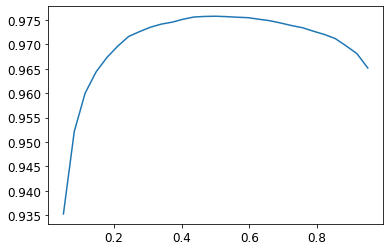

In [99]:
## lub profesjonalnie:
xs = torch.linspace(.05, .95, 29)
accs = [accuracy_multi(preds, targs, thresh = x, sigmoid = False) for x in xs]
plt.plot(xs, accs)

In [105]:
max(accs), xs[accs.index(max(accs))]

(TensorImage(0.9757), tensor(0.5000))

In [107]:
accuracy_multi(preds, targs, thresh = .5, sigmoid = False)

TensorImage(0.9757)